In [1]:
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [2]:
from torch import nn, Tensor
import torch.nn.functional as F
import torch
import math
from torch.autograd.variable import Variable
import typing
import random
import tqdm
import matplotlib.pyplot as plt
import IPython

In [3]:
%matplotlib inline

In [4]:
import os

modelname="5_4_23_m1"

prefix_models="models/"+modelname+"/"

if not os.path.exists(prefix_models):
    os.makedirs(prefix_models)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        #mine is [batch, seq, embed]
        x = x.permute((1,0,2))
        x = x + self.pe[:x.size(0)]
        dropout = self.dropout(x)
        return dropout.permute((1,0,2))

In [7]:
class ScaledDotProductAttention(nn.Module):
    def forward(self, query, key, value, mask = None):
        key_tp = key.transpose(-2, -1)

        scores = query.matmul(key_tp) / math.sqrt(query.size()[-1])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))
            
        attention = F.softmax(scores, dim = -1)

        return attention.matmul(value)

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 in_features,
                 head_num,
                 bias=True,
                 activation=F.relu):
        super(MultiHeadAttention, self).__init__()
        if in_features % head_num != 0:
            raise ValueError('`in_features`({}) should be divisible by \
                `head_num`({})'.format(in_features, head_num))
        self.in_features = in_features
        self.head_num = head_num
        self.activation = activation
        self.bias = bias
        self.linear_q = nn.Linear(in_features, in_features, bias)
        self.linear_k = nn.Linear(in_features, in_features, bias)
        self.linear_v = nn.Linear(in_features, in_features, bias)
        self.linear_o = nn.Linear(in_features, in_features, bias)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.linear_q(q), self.linear_k(k), self.linear_v(v)
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)

        q = self._reshape_to_batches(q)
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1)   
        
        y = ScaledDotProductAttention()(q, k, v, mask)        
        
        y = self._reshape_from_batches(y)      

        y = self.linear_o(y)
        if self.activation is not None:
            y = self.activation(y)
        return y

    @staticmethod
    def gen_causal_mask(x):
        batch_size, seq_len, _ = x.size()
        return torch.tril(torch.ones(seq_len, seq_len)).view(1, seq_len, seq_len).repeat(batch_size, 1, 1)

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.head_num
        return x.reshape(batch_size, seq_len, self.head_num, sub_dim)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size * self.head_num, seq_len, sub_dim)

    def _reshape_from_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        batch_size //= self.head_num
        out_dim = in_feature * self.head_num
        return x.reshape(batch_size, self.head_num, seq_len, in_feature)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size, seq_len, out_dim)

In [9]:
class Transformer(nn.Module):
    def __init__(self, 
                 embedding_dim: int,
                 n_self_heads: int,
                 n_features: int,
                 n_layers: int,
                 n_classes: int):
        super().__init__()

        #Embedding layer
        self.embedding = nn.Embedding(n_features, embedding_dim)
        #Positional encoding
        self.pos_encode = PositionalEncoding(embedding_dim)

        self.decoder_layers = []

        for _ in range(n_layers):
            layer = []
            #Add multihead, which will be cross or self attention
            layer.append(MultiHeadAttention(embedding_dim, n_self_heads)) #self attention first, masked
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))
            #Add a feed forward
            layer.append(nn.Linear(embedding_dim, embedding_dim))
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))

            self.decoder_layers.append(nn.ModuleList(layer))
        self.decoder_layers=nn.ModuleList(self.decoder_layers)

        self.to_out = nn.Linear(embedding_dim, n_classes)
            
    def forward(self, x: torch.Tensor, calculate_loss: bool = False):
        """
        Expect tensor of [batch_size, n_features]
        """
        if calculate_loss:
            #If give model that accepts ?x?x4 abcd, expect bcd0
            
            target_logits=torch.cat([x[:,1:], torch.zeros((x.shape[0],1)).to(device)], dim=-1) ## if x is abcd, then target_logits is bcd0

        x=x.long().to(device)
        embed = self.embedding(x)
        pos_encode = self.pos_encode(embed)

        res = embed+pos_encode
        
        for decoder_layer in self.decoder_layers:
            d_self_attention = decoder_layer[0]
            d_layer_norm_1 = decoder_layer[1]
            d_ff = decoder_layer[2]
            d_layer_norm_2 = decoder_layer[3]
            
            ## Run the decoder
            #do masked self attention
            mask = MultiHeadAttention.gen_causal_mask(res).to(device)
            res = res + d_self_attention(res,res,res, mask = mask)
            self_res = res
            #layer norm
            res = d_layer_norm_1(res)

            #do ff
            res = self_res + d_ff(res)
            #layer norm
            res = d_layer_norm_2(res)

        out = self.to_out(res)
        if calculate_loss:
            loss = nn.functional.cross_entropy(out.permute(0, 2, 1), target_logits.long())
            return out,loss
        return out

In [10]:
class Tokenizer:
    def __init__(self, n_pad: int, device: torch.device, pad_byte: int = 0, split: str = "\n"):
        self.n_pad = n_pad
        self.device = device
        self.pad_byte = pad_byte
        self.split = split

    def tokenize_str(self, sentence: str, encoding = "utf8") -> torch.Tensor:
        base = [int(i) for i in bytes(sentence, encoding)]
        if len(base) < self.n_pad:
            base.extend([self.pad_byte] * (self.n_pad - len(base)))
        assert len(base) == self.n_pad, f"n_pad is too small, use {len(base)} or greater."
        tensor = torch.Tensor(base)
        return tensor.to(self.device)

    def texts_to_sequences(self, texts: typing.List[str], encoding = "utf8") -> torch.Tensor:
        # tokenize the input text
        sentences = []
        for sentence in texts:
            sentences.append(self.tokenize_str(sentence).unsqueeze(0))

        return torch.cat(sentences, dim = 0).to(self.device)
    
    @staticmethod
    def prepare_texts(document: str) -> typing.List[str]:
        return filter(lambda x: len(x)!=0, document.split(self.split))
    
    def sequences_to_texts(self, texts: torch.Tensor, encoding = "utf8") -> typing.List[str]:
        out = []
        for seq in texts:
            chars = []
            i=0
            while i<len(seq) and seq[i] != 0:
                chars.append(int(seq[i]))
                i+=1
            out.append(bytes(chars).decode(encoding, "replace"))
        return out

In [11]:
def generate(seed: str, cutoff: int = 1024) -> str:
    output = torch.tensor([list(bytes(seed,"utf8"))]).to(device)
    
    res=output
    last = -1
    i=0
    while last != 0 and i<cutoff:
        res = model(output)
        argmax=res.argmax(-1)
        
        out = list(output[0])
        out.append(list(argmax.to(device)[0])[-1])
        last = list(argmax.to(device)[0])[-1]
        output = torch.tensor([out])
        i+=1
    
    if last == 0:
        return convert_to_str(output)
    return convert_to_str(output)+"<CUTOFF>"

In [12]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data: typing.List[str], n_pad):
        self.raw_data = data
        self.tokenizer = Tokenizer(n_pad, device, split = "\0")
        
    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self,index):
        return self.tokenizer.tokenize_str(self.raw_data[index])

In [13]:
def convert_to_str(x: torch.Tensor) -> str:
    #Expects [1, 256] tensor
    bts = []
    i=0
    while len(bts)<x.shape[1] and x[0][i] != 0:
        bts.append(int(x[0][i]))
        i+=1
    return bytes(bts).decode("utf8","replace")

In [14]:
n_features = 256 # No. of tokens
n_pad = 512 # Max line length
embedding_dim = 640
batch_size = 32
head_factor = 64
assert embedding_dim%head_factor == 0
head_size = embedding_dim//head_factor
print(f"Head size: {head_size}")
n_layers = 14

Head size: 10


In [15]:
path_to_data = "data/reddit_scrape_v8.txt"
data_raw = open(path_to_data, encoding="utf-8").read()

data_split = list(filter(lambda x: x!="", data_raw.split("\0")))
random.shuffle(data_split)

train_data = data_split[100:]
print(len(train_data))
val_data = data_split[:100]

train_dataloader = TextDataset(train_data, n_pad)
test_dataloader = TextDataset(train_data, n_pad)

dataloader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataloader , batch_size=1)
testloader_iter = iter(testloader)

187129


In [16]:
model = Transformer(embedding_dim, head_size, n_features, n_layers, 256)
model=model.to(device)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model), "trainable params")

29080576 trainable params


In [18]:
input=next(testloader_iter)
input=input.to(device)
print(input.shape)
res = model(input)
print(res.shape)

torch.Size([1, 512])
torch.Size([1, 512, 256])


In [19]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [20]:
n_epochs = 40

In [21]:
!nvidia-smi

Thu May  4 15:40:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          On   | 00000000:06:00.0 Off |                    0 |
|  0%   73C    P0    84W / 150W |   1506MiB / 23028MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
print(device)

cuda


In [23]:
prompts = [
    "Why does Earth orbit the Sun?",
    "Hello world, ",
    "How to use ChatGPT?",
    "My code does not work. What should I do?",
    "Why is this code not working: `1+\"A\"`?",
    "Why is Java better than Python?",
    "Why is Python better than Java?",
    "What is the purpose of the main() function in C?",
    "What is coding?",
]

Epoch 1


100%|██████████| 5848/5848 [1:13:01<00:00,  1.33it/s]


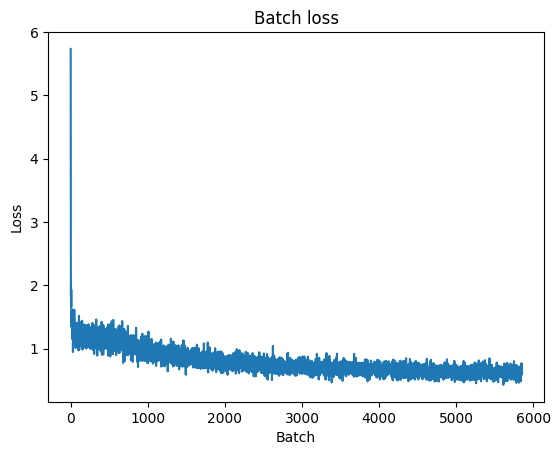

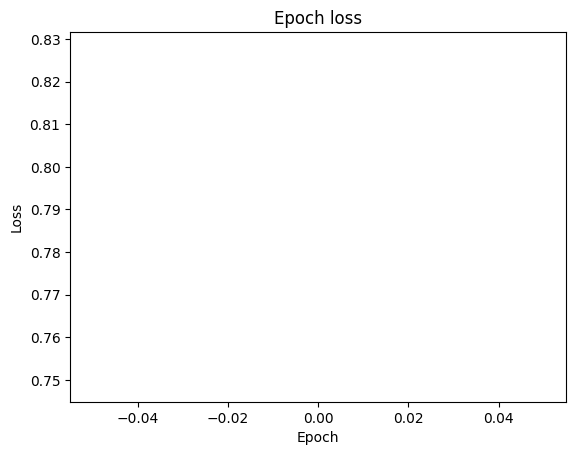

Prompt 0: Why does Earth orbit the Sun?
Model output (markdown): 

Why does Earth orbit the Sun?
I think it with the string the string the string the string to string the string the string to the string the string the string to the string the string to the string the string the string the string the string the string the string the string the string the string the string the string the string the string the thend the thend the thend the then the then the then the then the then the thend the then the then the the then thing the thest the the then thing the thest the the the thentes the the the thest thent thellle thes thent thelllles th.


Prompt 1: Hello world, 
Model output (raw): Hello world, std:::tring to string the string in the string of the string in the block in the block in the block in the block in the block in the blocked in the blocked in the blockend in the blockend in the blockend in the blockend in the blockend in the blockend in the blockend in the blocken in the blocken in the block in the block in the block in the bloop in                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

My code does not work. What should I do?
I want to build in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book into internal intender intentioneg intentionence intentionence intentionence intentionel intend intentionel intentionel intentionel intentioneg into intentioneg intentionel intentioneg intentioneg intentioneg intentionel intentionel intenting intentionel intentiong intentiong intentiong intentioureng inthing inthing inthing inthingling ithing induts indutrentioreng its indutrentinguts.


Prompt 4: Why is this code not working: `1+"A"`?
Model output (markdown): 

Why is this code not working: `1+"A"`?
I think it's a string to the string the string the string the string to the string the string the string to the string the string the string to the blind the blind the blind the block the block the block the thend the thend the thend the thend the thend the then the thend the the the thend the then the the the the the the the the the the the the the the the the the thend the thend the thend the thend the thend the thend the thing the thing thing thent thest thing the thind the thind thest intelling it thes inthit int inthit it inthit it in ithes ithit it it ind ithit it it it ind ithit it it it it ithit  thit  thindut.


Prompt 5: Why is Java better than Python?
Model output (raw): Why is Java better than Python?
I think it with the best in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book in the book into internal internal internship into intentioneg internal inderesting intentioneg intentioneg intentioneg intentioneg                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Why is Python better than Java?
I think it with the standard in the biggest in the standard in the standard in the standard in the string the string the string the string the string the string the string the string the string the string the string the string the string the string the string the string the string the string the string the string the string the string the then the then the the thend the thend the thend the thend the then the then the thing the thest thest the thest the the the the thest the the thest the the thestellle tellles tellling test.


Prompt 7: What is the purpose of the main() function in C?
Model output (markdown): 

What is the purpose of the main() function in C?
I was the string the string the string the string the string to the string the string in the string the string the string the string to the string the string the string the string the string the string the string the string the string the string the string the string the string the thend the string the thend the thend the then the then the then the then the thend the then the thend the thend the then thing the thing thest thest thest the thing the thing intes intententiong intentlling thes thelling thing thest thind ind thind ind ind ithit ind ithing it ind ithit ing int ind ithing ithing it.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I don't know what it is the blackent in the black is the string to start in the string the string the string the string to string the string the string to the string the string the string the string the string the string the string the string the string the string the string the string the string the string the string the string the the thend the thend the then the then the thend the thend the thend the thend the thend then thend the then thing the thing thest thest the thing thest thest thest thest thestent.


Epoch 2


100%|██████████| 5848/5848 [1:12:59<00:00,  1.34it/s]


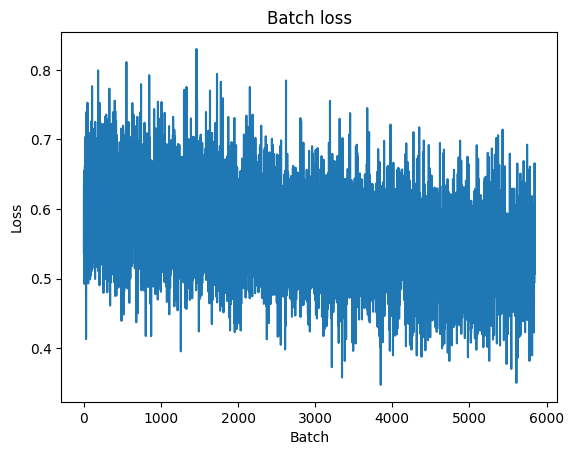

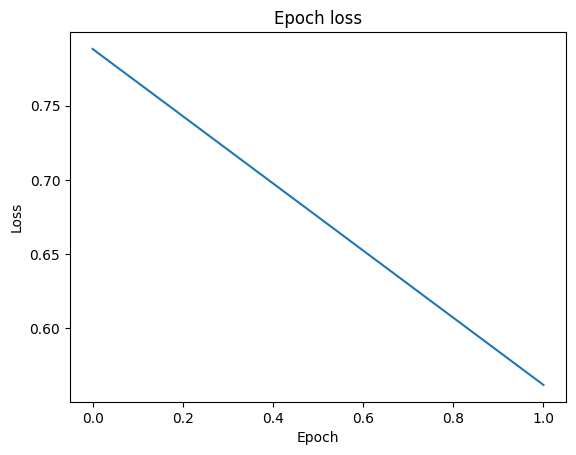

Prompt 0: Why does Earth orbit the Sun?
Model output (markdown): 

Why does Earth orbit the Sun?
I think it would be a subscribence in then then then then internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet indext internet indext internet indext internet indext internet indext internet indext internet indext internet indext internet ind internet ind ind internet ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind rendusing ind ind rendus ind ind ind rendund ind ind rend ind rindund rex ound rndund orind rex rndundund rind rex


Prompt 1: Hello world, 
Model output (markdown): 

Hello world, newsted stdies.
I think the standing the standing is to the standard then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then thenore thenore thenorenence thenorenence thenorenencencent thenorenencent thenorenence thenorenencent thenorenencent thenorenence thenorenencent thenorenencencenct thenorenencencenct thenorenence thenorenencencenct thenorenencencenct thendornenenct thind thindsenens.


Prompt 2: How to use ChatGPT?
Model output (markdown): 

How to use ChatGPT?
I don't unstallized the stack installing then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then thenoric thenoring thenorience thenoring thenorience thenoring thenorience thenorience thenoring thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenoriencent thinist thenist thining thendining thining thining threniorining thing thrining thring thinding threndininining oring thring thring threndining oring thring thrend orind thring thring thing thring thring thring rend thrind rend thind rind rend rind ind rndundund rinind ind rind rind rend rind rind rend rind ind rndundunininininining ring rening ring rents.


Prompt 3: My code does not work. What should I do?
Model output (markdown): 

My code does not work. What should I do?
I don't know who things work with then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then thenore thenoreg thenorient thenorience thenoring thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenorience thenorience thinist thendining thinit thendinining thining thring thendininioring thing thrinding thring thring threninding thring thrind thring thrending thrind thring thrend thrind thrind bex bendundindining ring rind rind rend rind rend rndundundunining ring rind rind rend rindund rind rend rindundinching rinching


Prompt 4: Why is this code not working: `1+"A"`?
Model output (markdown): 

Why is this code not working: `1+"A"`?
I think it is and then then it is and then then it is to the only then then then it is on the complete then internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet ind internetioret internetioret indusine index indutrencentinent threllouggend ind index indutserndinex.


Prompt 5: Why is Java better than Python?
Model output (markdown): 

Why is Java better than Python?
I don't know if it's anyone who is problem to be a problem in problem in problem internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet indext internet indext internet internet indext internet indext internet indext internet indext internet indext internet ind index internet ind indext ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind ind rendusing ind ind rendusing ind rindundus.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I did this in the best in in the standard in internship in the best in internship in the internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internetioret indusing index indutrencent thernd indutsernex.


Prompt 7: What is the purpose of the main() function in C?
Model output (markdown): 

What is the purpose of the main() function in C?
If the course it it in the court it in then it intending it intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending intending inding inding indiniting thunding indits thunding thorending orndunding ornduthand ththing thind threndind orend ind thind thundinding orend orndind orndundining orndining oring ornd rndundundining orororing orng orndund rndundunduninining orororing rng orndundunining orororng rning ornduninining orororng orning orng rndunduninininining ororororor.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I was cooler cooler color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color color colorger color colorger color colorger colorger color colorger colorcerence.


Epoch 3


100%|██████████| 5848/5848 [1:12:50<00:00,  1.34it/s]


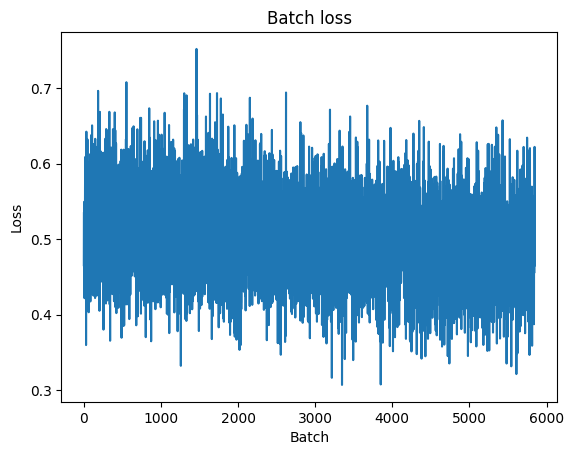

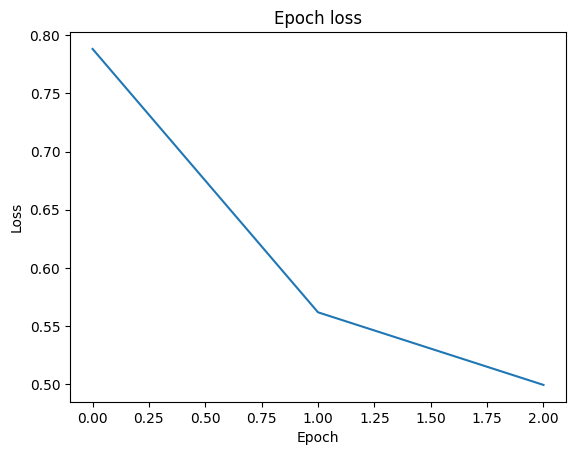

Prompt 0: Why does Earth orbit the Sun?
Model output (markdown): 

Why does Earth orbit the Sun?
I think is a sun in the sun is a sun internship is and it is and it is and it is and it is and it internships is the sunder internships internships is therefore internships internships is therefore internships internships is thereforences. It sundering is and is and is and is and is and is and is and is and is and is and is and is and is and is and is and is on is onder is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is is.


Prompt 1: Hello world, 
Model output (raw): Hello world, nobooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo

How to use ChatGPT?
I don't know who and is and then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then then thend thend thend thend thend thnend thnend thend thnend thend thnend thind thend thind thinds thind thind thind thinds thind thind thind thind thind thind thind thind thind thind thind rmmminininining ininit.


Prompt 3: My code does not work. What should I do?
Model output (markdown): 

My code does not work. What should I do?
I do think is and is a but is and it is and it is and it is and it is and it interface in iterface is and iterface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interfaceces interfaceces interfaceces.


Prompt 4: Why is this code not working: `1+"A"`?
Model output (raw): Why is this code not working: `1+"A"`?
I think it is and it is a something is and it is and it is and it it is and then it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it it  itit  it  itit  itit  itinining it it it itin it  itit orend itiniting orentinious orniting ithing ithiting ithing ithiting ithininining ititininining itininitininiousing itinitininitiniousing itinitininitiniousing itinitininiting itininitinitioninitioning itininitinitiniousing itininitinitiniting itinitinininititininitininitingioriniting itinitinginitinitininitinitininitinginitiniting itinitini

Why is Java better than Python?
I don't know what is in the issue is in internet is internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet ornethint ornenet thnex internternet ornethnet rnethnet ornethnet rnethnethnet ornethnet rnethnethnet ornethnet rnethnethnet rnethnethnet nethnethnethnernet.


Prompt 6: Why is Python better than Java?
Model output (markdown): 

Why is Python better than Java?
I don't know what is in the issue is in internship is and is internships and is internships and issumes internships and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and issumes and is and is and is and is and is and is and is and is and is and istangusting ishis is storesument.


Prompt 7: What is the purpose of the main() function in C?
Model output (markdown): 

What is the purpose of the main() function in C?
I don't know what is in the standard is in the standard in the is internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet internet thind internet internet ornex inthint ornthenernet ornethnet ornd thnex thint ornthinernet.


Prompt 8: What is coding?
Model output (markdown): 

What is coding?
I think is and is and then it is and then it is and then it is and then it it is then it interface then it is then it interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interface interfacece interfaceces interfaceces intentintionioustioning industiniong indutinioninioring orenthing orenthing orenthinthing orenthing orenthinthing orenthing orffffacentstiorinting onththing oring ornthththing oring oringhththththing bling oringhthththing bling oringhththththing bling oringhthththing bling bling orinththththththings.


Epoch 4


  9%|▉         | 545/5848 [06:46<1:05:57,  1.34it/s]

In [ ]:
model.train()

epoch_losses = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    
    batch_losses = []
    for data in tqdm.tqdm(dataloader):
        optimizer.zero_grad()

        data = data.to(device)

        output, loss = model(data, True)
        
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        
    epoch_losses.append(sum(batch_losses)/len(batch_losses))

    plt.plot(range(len(batch_losses)),batch_losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Batch loss")
    plt.show()

    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Epoch loss")
    plt.show()

    torch.save(model, prefix_models+f"model_E{epoch}")

    with open(prefix_models+"losses.txt", "a") as f:
        f.write(f"{epoch_losses[-1]}\n")
        
    scheduler.step()    
    
    with torch.no_grad():
        for i, prompt in enumerate(prompts):
            print(f"Prompt {i}: {prompt}")
            output=generate(prompt)
            if not output.strip().endswith("<CUTOFF>"):
                print(f"Model output (markdown): ", end="")
                IPython.display.display(IPython.display.Markdown(output))
            else:
                print(f"Model output (raw): {output}")
            print()



In [ ]:
model = torch.load(prefix_models+"model_E0")

with torch.no_grad():
    for i, prompt in enumerate(prompts):
        print(f"Prompt {i}: {prompt}")
        output=generate(prompt)
        print(f"Model output: {output}")
        print()


In [ ]:
import builtins
while True:
    prompt = builtins.input(">>> ")
    output=generate(prompt)
    print(f"Model output: {output}")
    print()